![MLU Logo](../data/MLU_Logo.png)

# Assignment 4

## Related Reading
If you want to read more about these concepts, I'll be putting links here for you to find various resources.
* [Understanding Random Forests](https://arxiv.org/pdf/1407.7502) Sections 4.4.2, 4.4.3, and 6.
* [A few warnings about feature importances](http://explained.ai/rf-importance/index.html), a blog post about feature importances
* [ Bias in random forest variable importance measures: Illustrations, sources and a solution](https://link.springer.com/article/10.1186%2F1471-2105-8-25), a paper explaining the issues encountered with over-inflation of importances.

## This Assignment's Goals
We'll see how to implement proximities.

In [ ]:
! pip install -q -r ../requirements.txt

## Random Forest Proximities

The first thing we want to look at are random forest proximities.  This are a bit annoying, since it isn't implemented by default, so we need to do it ourselves!  Before doing so, I'm going to bring in our Fashion MNIST dataset again.

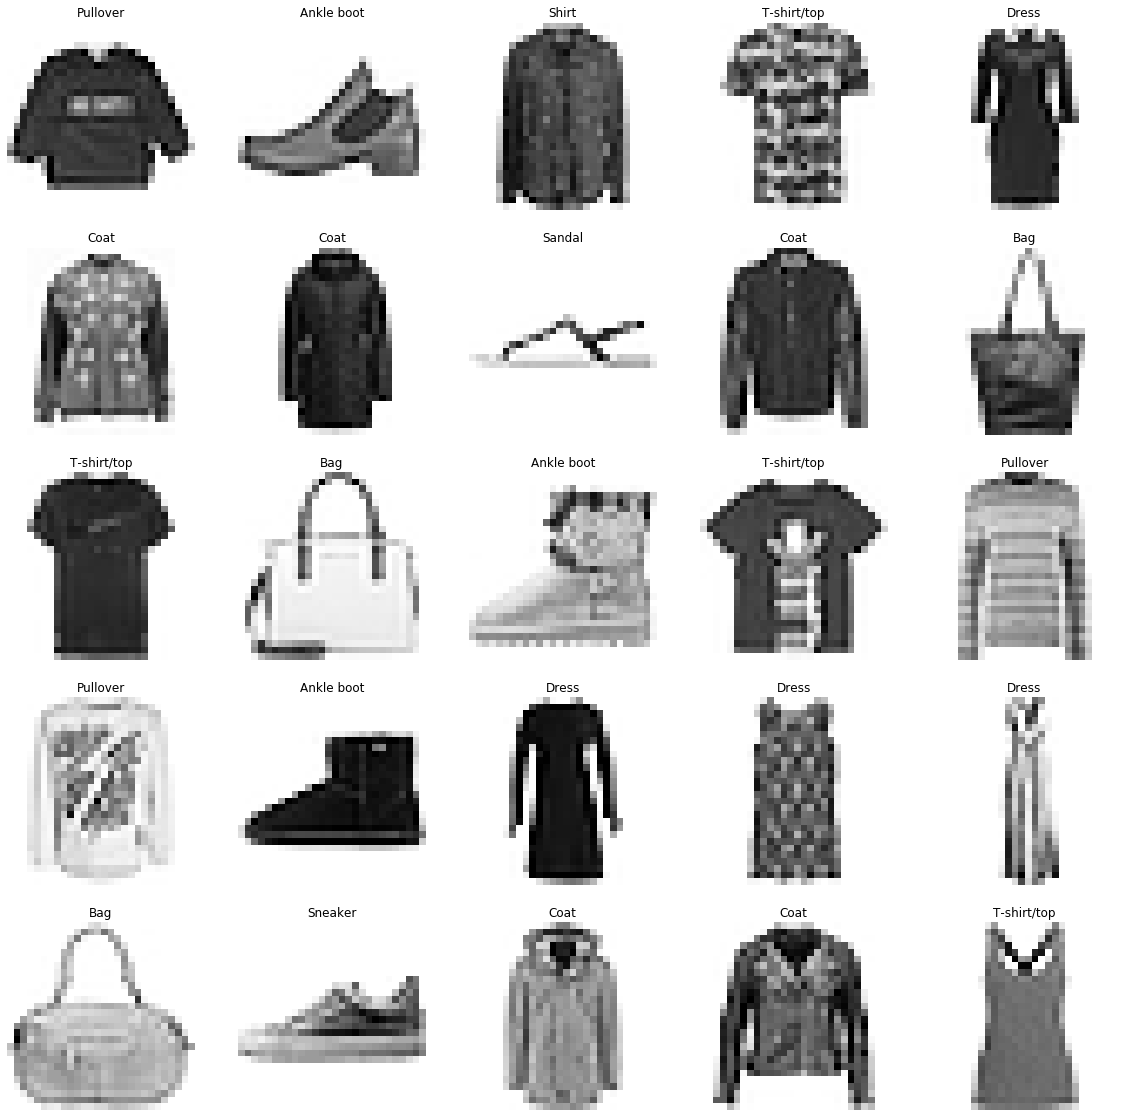

In [1]:
### Load Fashion MNIST ###

from mxnet import gluon
import numpy as np

# Grab the FashionMNIST dataset
x_train, y_train = gluon.data.vision.FashionMNIST(train=True)[:]
x_test, y_test = gluon.data.vision.FashionMNIST(train=False)[:]

x_train = x_train.asnumpy()
x_test = x_test.asnumpy()

# reshape and scale to be in [0,1]
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train /= 255
x_test /= 255

import matplotlib.pyplot as plt

# Plot a handful of examples
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(20,20))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(x_train[i].reshape(28,28),cMap = 'Greys')
    plt.title(classes[y_train[i]])
    plt.axis('off')
plt.show()

### Question 1
> Implement the random forest proximity as described in class.  The key is the ```apply``` function of the ```RandomForestClassifier``` (or ```RandomForestRegressor```) which tells you which leaf node was used for every tree in the forest.  Train the random forest on all of ```x_train``` and ```y_train``` and then have it compute the proximities on the first $1000$ elements of ```x_test```.  These should be converted to dissimilarities by either taking $1-s$ or $-\log(s+0.0001)$ to obtain distances.  Use [MDS](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html) to reduce the dimension to $2$ and plot the resulting scatter plot.  Note that you should set the```dissimilarities = 'precomputed'```in the MDS since we have computed them by hand. It should be pretty resilient to changes of the random forest, but ```RandomForestClassifier(n_estimators = 64, max_depth = 12, max_features = 32, n_jobs = -1, verbose = 1, random_state = 8675309)``` works well.  Which clusters are clearly separated and which ones are not?

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:   37.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:    0.0s finished


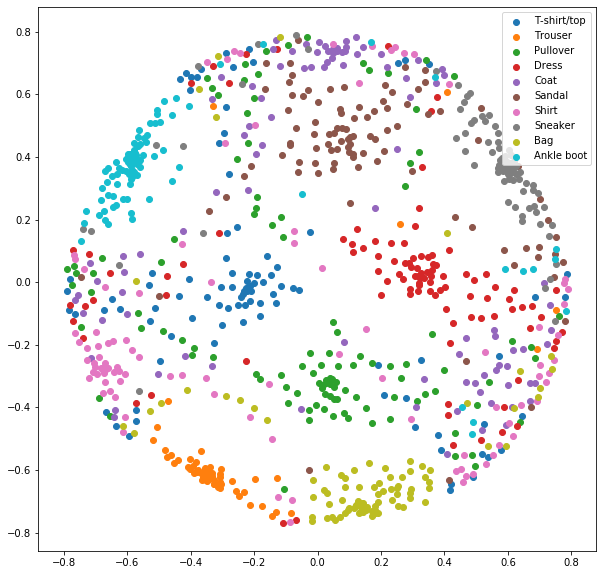

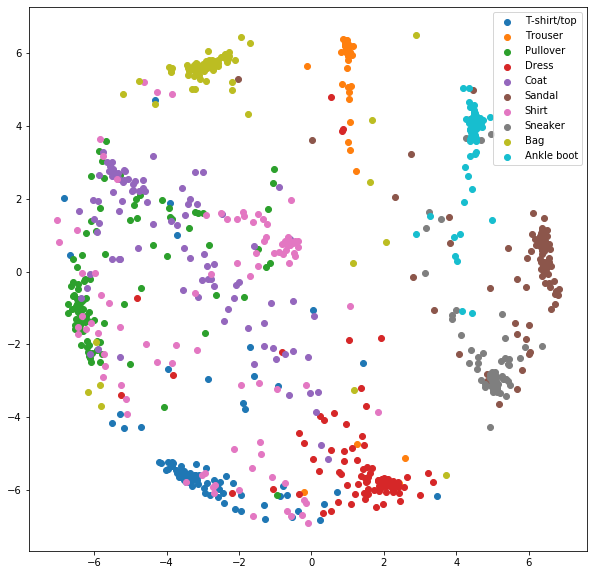

In [2]:
### Question 1 ###

### Answer 1 ###

# build our model
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 64, max_depth = 12, max_features = 32, n_jobs = -1, verbose = 1, random_state = 8675309)
clf.fit(x_train,y_train)

# Compute Similarities

def sim(X):

    leaves = clf.apply(X)
    out = np.zeros((len(X),len(X)))
    for i in range(X.shape[0]):
        for j in range(X.shape[0]):
            out[i,j] = np.mean(leaves[i] == leaves[j])
    return out

# Compute them for the first 1000 points
s = sim(x_test[0:1000])
# A little plotting routine

def plot_reduced(red):
    plt.figure(figsize=(10,10))
    
    for i in range(10):
        sub = red[y_test[0:len(red)]==i]
        plt.scatter(sub[:,0],sub[:,1],label=classes[i])
    plt.legend()
    plt.show()
    
# Plot for 1-s
from sklearn.manifold import MDS

drd = MDS(dissimilarity='precomputed', random_state = 8675309)
red = drd.fit_transform(1-s)
plot_reduced(red)

# Plot for -log(s)
drd = MDS(dissimilarity='precomputed', random_state = 8675309)
red = drd.fit_transform(-np.log(s+0.0001))
plot_reduced(red)

### Answer 1

The fuzzy classes seem to be shirt being mixed with t-shirt, coat, and pullovers. Sneaker with sandals and ankle boots.It can be a bit hard to see.

## Checking the Proximity Visualizations

If a visualization is to reflect the real world, it had better tell you correct statements about you data and model.  In particular, overlapping clusters should correspond to difficult decisions, which should correspond to frequently made errors in the model.  We can thus check the validity of our model by computing the confusion matrix and verifying that indeed what we learned in the visualization is reflected in our model performance.

### Question 2
> Compute the [confusion matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) for the random forest we trained above on the entire test set and normalize the rows to sum to one (so you can tell the percent of each kind of error made).  Compare the commonly confused classes (which we will take to be the off-diagonal entries with at least 10% of the data in them) with the overlapping clusters in our visualization.  Do they match?

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


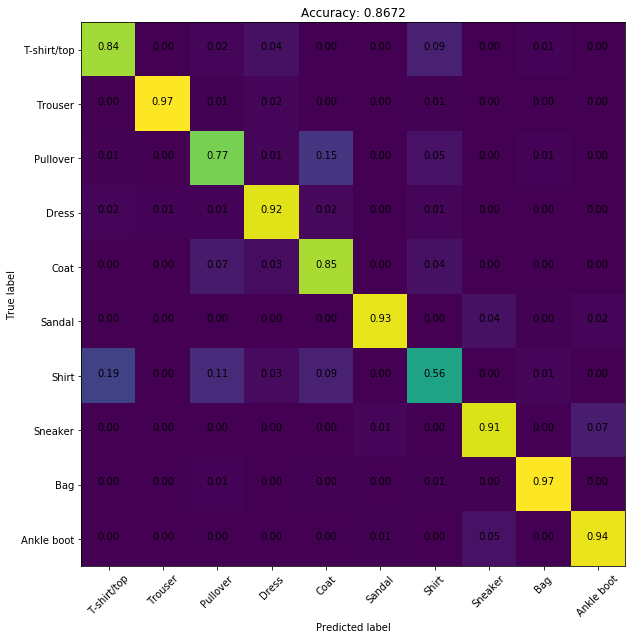

In [3]:
### Answer 2 ###

# Write code here.

from sklearn.metrics import confusion_matrix

# Compute and normalize it
cm = confusion_matrix(y_test,clf.predict(x_test))
cm = cm / np.sum(cm, axis=1, keepdims=True)

# Plot the confusion matrix
plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest')

# Label Everything
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

for i in range(len(classes)) :
    for j in range(len(classes)) :
        plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment = 'center', color = 'black')

plt.ylabel('True label')
plt.xlabel('Predicted label')

# Show it!
plt.title("Accuracy: {}".format(clf.score(x_test,y_test)))
plt.show()

### Answer 2

Here the mixed up classes are shirt with coat, pullover, t-shirts. Coat with pullover, and pullover with coat. This indeed matches with our visualization, which is great! Honestly, I can't tell the difference between these classes, so I think our model is doing well?

## Random Forests and Non-Linear Data Transformation
Now let's go through and see the next cool trick of random forests, the ability to be used as a non-linear supervised method for feature transformation that separates the classes.  In class we saw how this can be then fed into PCA for another method of model visualization, and how it can be fed into logistic regression as a set of features that are closer to linearly separable.  Let's dive in a little deeper into this last one.

### Question 3
> Write code to convert a data point into the vector of one-hot encoded leaf indices of our trees.  Use [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) to learn a regularized logistic regression on these one-hot encoded data points.  Just to save time, use ```LogisticRegressionCV(Cs = 5, cv = 3)``` to do a quick search for a reasonable value of the regularization.    Plot the resulting normalized confusion matrix again.  What has improved the most? 

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:    0.2s finished
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs faile

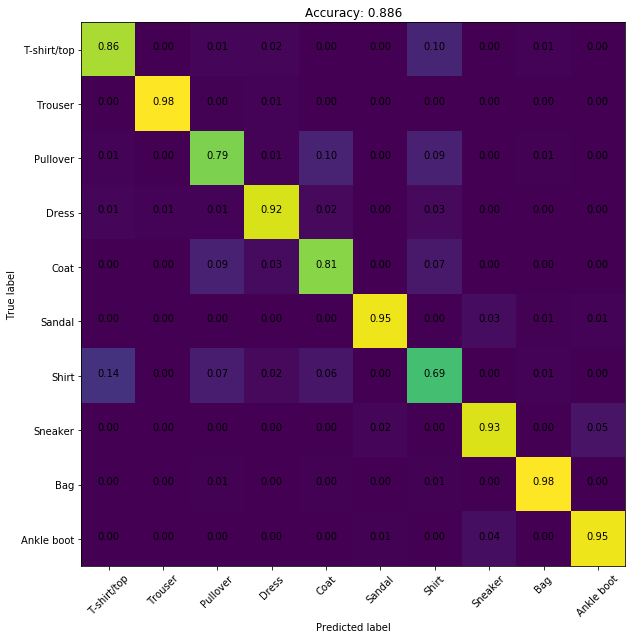

In [4]:
### Answer 3 ###

# Write code here.

from sklearn.preprocessing import OneHotEncoder

# Encode the Data
leaves_train = clf.apply(x_train)
leaves_test = clf.apply(x_test)
enc = OneHotEncoder(handle_unknown='ignore')
ohe_train = enc.fit_transform(leaves_train)
ohe_test = enc.transform(leaves_test)

# Train our model
from sklearn.linear_model import LogisticRegressionCV
reg = LogisticRegressionCV(Cs = 5, cv = 3)
reg.fit(ohe_train,y_train)

# Compute and normalize it
cm = confusion_matrix(y_test,reg.predict(ohe_test))
cm = cm / np.sum(cm, axis=1, keepdims=True)

# Plot the confusion matrix
plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest')

# Label Everything
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

for i in range(len(classes)) :
    for j in range(len(classes)) :
        plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment = 'center', color = 'black')

plt.ylabel('True label')
plt.xlabel('Predicted label')

# Show it!
plt.title("Accuracy: {}".format(reg.score(ohe_test,y_test)))
plt.show()

### Answer 3

We see improvement fairly strongly across the board. The most significant change is the increase in precision in the shirt category where is is now 69% correct rather than 56%. There are the same number of off-diagonal elements, greater that 0.1 but they are overall reduced in severity.

### Question 4
> Now apply these techniques to your ongoing final project.  A few guiding questions:
> * Can you use the feature importances to re-examine the encoding you are doing?
> * Can proximities help you identify where the mistakes are being made?  
> * Can you take the implicit non-linear feature transformation of a random forest and use it to feed in to another algorithm to get additional gains?

In [5]:
### Answer 4 ###

# Write code here.